# Exploratory Data Analysis 

Goal: Explore the data, clean it up, and deliver a properly formatted output to the visualization code
Author: John Stayner
2020-12-29

Background: I've worked on solar-powered vehicles for ~7 years now, and I've always been frustrated by the lack of a way to integrate IV curves with the actual power/current/voltage values. Solar power is generally a function of quite a few variables, and putting them all on the screen at the same time in a way that's easily readable is not an easy feat. 

I was never able to justify doing this while working on a project with high opportunity costs, but now that I'm funemployed I've got time to make it work!

I'll also be using this as a way to learn fancy documentation libraries (like Sphinx) and how to set up unit testing, which are two things I've always wanted to add to my code but have never had the time for

In [ ]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

plt.style.use('seaborn')  # Personal preference

In [34]:
# Import data and get a sense of what it looks like.

fname = 'data/sundae_mppt_day_5/mppt_A0_current.csv'  # Relative path to data

df_raw = pd.read_csv(fname, header=None)

df_raw.head()

,0,1
0,1507754339299,0.0
1,1507754339327,0.0
2,1507754339375,0.0
3,1507754339425,0.0
4,1507754339484,0.0


In [35]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383698 entries, 0 to 383697
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       383698 non-null  int64  
 1   1       383698 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 5.9 MB


Observations:
* It looks like the first column is probably some version of unix epoch (seconds since January 1970)
* Judging from the name of this file (mppt_A0_current), the second column is probably current
    * So, the telemetry probably creates a csv file for each data flow. This creates some extra work for us, but stitching everything together isn't too difficult. 
* 5.9 MB is a lot for a dataframe we don't care about!!! We'll probably want to either shorten this data or resample it once we've scraped IV curves out of it. 
* No NaN values, so we're good there. 

First step: Let's see if that first column is indeed UNIX time

In [36]:
# Is the first column unix time?

df_short = df_raw[:100]  # Don't need the full dataframe for this

for time_unit in ['ns', 'ms']:

    time_col = pd.to_datetime(df_short.iloc[0,:], unit=time_unit)
    print('{}: {}'.format(time_unit, time_col[0]))


ns: 1970-01-01 00:25:07.754339299
ms: 2017-10-11 20:38:59.299000064


Looks like it's milliseconds since 1970! I originally tried adding seconds, but got an out of bounds error. Note that this is probably UTC since it's saying that it's 8:40 PM, but the first entries here should be near sunrise in Australia (~6:20 AM). Given Darwin is UTC+9:30, 8:40 PM on 10/11 puts us at right around 6:10 AM on 10/12. 

Next up: Let's plot this to see if the second column has values that pass a sanity check to be current values from our SunPower cells. The values should be ranging from 0 to ~7 A at the absolute highest (in practice, the ~7 A is rare since we only sun-pointed the car during sunrise and sunset)

What we should see here is a low value that increases until ~8 AM, when we stop sun-pointing. It should then follow the normal solar parabola until ~5 PM, when we get off the road and start sun-pointing again. 

In [ ]:
# Note: Leaving the output of this cell available significantly increases size, so I've left it out. 

# Rename columns to what we think they should be
mppt_A0_curr = df_raw.rename(columns={0: 'time', 1: 'current'})

# Modify time
time_zone_diff = 9.5  # Darwin is  UTC + 9:30
mppt_A0_curr.loc[:, 'time'] = pd.to_datetime(mppt_A0_curr.loc[:, 'time'], unit='ms') + \
                                pd.Timedelta(time_zone_diff, unit='hours')

# Plot! Using matplotlib for this since it's 5 MB of data. 
plt.scatter(mppt_A0_curr['time'], mppt_A0_curr['current'], s=5)

Looks like what we would expect! This does indeed seem to be time series data for current from one of the solar panels on the car. Lots of IV Curves, though. I've generally found that to be an easier problem to solve when we have integrated voltage/current data instead of just current, so we'll wait to solve that problem until we have everything stitched together. 

To stitch time series together, we have two options:

1. (Vastly preferred) If you're lucky enough that everything's sampled at the same rate and at the same time, then you can just join all the dataframes. Sadly, this generally doesn't actually happen. 

2. Interpolate each time series onto one time vector. This doesn't work very well with IV curves, though, so we'll probably have to scrape IV curves first and hope that each MPPT was consistent with measurement time between voltage and current measurements. At worst, we can use a "nearest" interpolation instead of a linear interpolation to line up the IV curve points, and check to make sure that doesn't cause anything weird to pop up. 


In [ ]:
# To start, let's load up the voltage for this specific MPPT and compare the time columns. 

path_voltage = 'data/sundae_mppt_day_5/mppt_A0_volt_in.csv'
df_volts_raw = pd.read_csv(path_voltage, names=['time', 'voltage'])

df_volts = df_volts_raw.copy()
df_volts.loc[:, 'time'] = pd.to_datetime(df_volts.loc[:, 'time'], unit='ms') + \
                                pd.Timedelta(time_zone_diff, unit='hours')

df_volts.head()

In [ ]:
# Now, let's see if the time values are all the same. 
time_diff = mppt_A0_curr['time'] - df_volts['time']

time_diff.max()

Good! It looks like this MPPT, at least, is consistent on its time values. Note that the command above gives us two pieces of info: 

1. The max difference is zero (all vals the same)

2. They're the same length, meaning no data was dropped from one but not the other. 

Next step: Join the dataframes and figure out how to separate out the IV curves. Probably won't show all my work for this one, since I tend to go trial and error for most of these; without a signal that goes high when the IV curve is being taken, I've always had to find what separates an IV curve from normal data and then use that to scrape the IV curves out. 

In [ ]:
# Join dataframes:

mppt_test = mppt_A0_curr.merge(df_volts, how='left', on='time')  # Use merge when joining by columns

mppt_test.head()

In [37]:
# Find an IV Curve and figure out some defining features

start = pd.to_datetime('2017-10-12 11:00:00')
end = pd.to_datetime('2017-10-12 11:30:00')

mppt_test_short = mppt_test[(mppt_test['time'] > start) & (mppt_test['time'] < end)]
# mppt_test_short = mppt_test[100000:10000]  

# mppt_test_short.plot(kind='scatter', x='time', y='current', s=5)
# plt.title('Looks like 6:20 has some interesting info')


# shorter.plot(kind='scatter', x='time', y='current', s=5)

px.scatter(mppt_test_short, x='time', y='current', title='Current: Check out 11:03!')


In [38]:
px.scatter(mppt_test_short, x='time', y='voltage', title='Voltage: Check out 11:03!')


<AxesSubplot:xlabel='voltage', ylabel='current'>

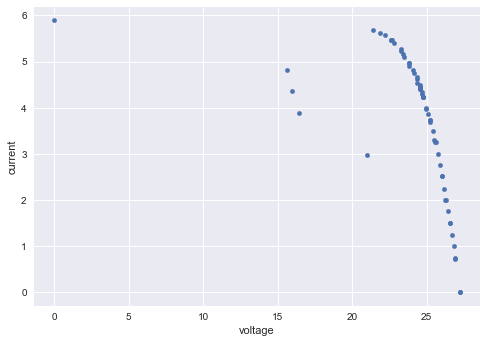

In [39]:
# I used the graphs above to zoom in on ~11:03:50:

start = pd.to_datetime('2017-10-12 11:03:48')
end = pd.to_datetime('2017-10-12 11:03:52')

test_IV_curve = mppt_test[(mppt_test['time'] > start) & (mppt_test['time'] < end)]

# px.scatter(test_IV_curve, x='voltage', y='current')  # Takes too much space
test_IV_curve.plot.scatter(x='voltage', y='current')

Well, there are a few interesting things here:
* Going by times, it looks like it sweeps down in voltage and up in current. In fact, it actually looks like this is setting current in order to take the IV sweep. The change in current vs time is roughly linear, while the change in voltage is nonlinear, and the top of the IV curve is missing (which tends to happen when sweeping using only current if the shunt resistance is low enough)
* There's some weird behaviour after the curve. Not sure what this is caused by; could be capacitance messing things up after the Isc measurement? I'd have to read up on this to make a real guess.
* Overall, this looks like a really nice module, which we'd expect for a solar car race array!
* IV Curves appear to be every ~5 minutes. 
* The best distinguishing feature that I can see here is that both voltage and current reach zero fairly close to each other; however, I'm not sure that's true of all the IV curves we have here. 
    * If you zoom in on the IV Curve at 11:20, we can see that the IV curve is missing some data in the middle, as well as the zero points in both current and voltage. 
    * Luckily, we don't need all the IV curves for this; we're just trying to get a sense of what's happening and visualize it. If we had any hardware failures, then we might want to start worrying about scraping all IV curves. 
    * So, other possibilities: High rate of change in voltage from normal operation to Voc, could take a set number of datapoints around that. That might get false positives though from shading, but it might be the best we can do. 

In [40]:
# Let's figure out how to scrape IV curves based on when voltage hits zero. 

# From the above, it looks like the Isc measurement (V=0) is taken last, so let's find x datapoints
# before that. The nice thing here is that since sunlight is fairly stable on these timescales, we 
# can make x fairly large and still be pretty sure that the data we're catching will be somewhere on this
# IV curve. 

num_datapoints = 40

# When working with small data, I like to initialize a new dataframe in cells that I'll be re-running a 
# lot (i.e. whenever I'm trying to make a graph look decent) to avoid any issues. 
scrape_test = mppt_test_short.copy()  

# Account for floating point errors. 
scrape_test['v0'] = (scrape_test['voltage'] < 0.01) & (scrape_test['voltage'] > -0.01)

# Now for the fun part: Pandas has a great rolling function that we can use to get the x datapoints 
# before the v0 signal goes high. Only problem is it normally doesn't do look-ahead, so we have to use
# the FixedForwradWindowIndexer to make that happen. 
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=num_datapoints)
scrape_test['IV_Curves'] = scrape_test['v0'].rolling(window=indexer, center=False).max()

start = pd.to_datetime('2017-10-12 11:03:45')
end = pd.to_datetime('2017-10-12 11:03:52')

test_IV_curve = scrape_test[(scrape_test['time'] > start) & (scrape_test['time'] < end)]

# Plotly subplots are not quite as elegant as the rest of the library right now
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add voltage subplot
fig.add_trace(
    go.Scatter(x=test_IV_curve['time'], y=test_IV_curve['voltage']),
    row=1, col=1
)
fig.update_yaxes(title_text='Voltage (V)', row=1, col=1)

# Add IV Curve boolean subplot
fig.add_trace(
    go.Scatter(x=test_IV_curve['time'], y=test_IV_curve['IV_Curves']),
    row=2, col=1
)
fig.update_yaxes(title_text='IV Curve?', row=2, col=1)
fig.update_xaxes(title_text='Time (Australian)')

# Update title and overall graph
fig.update_layout(title_text='Did we get the IV Curve?', showlegend=False)

fig.show()


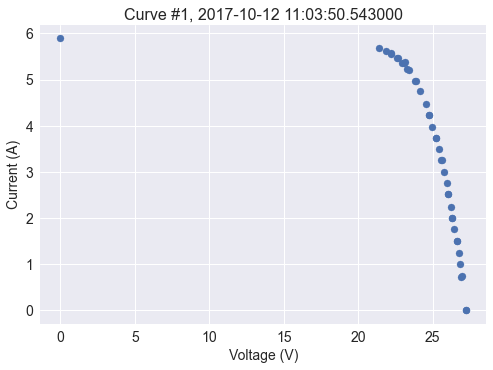

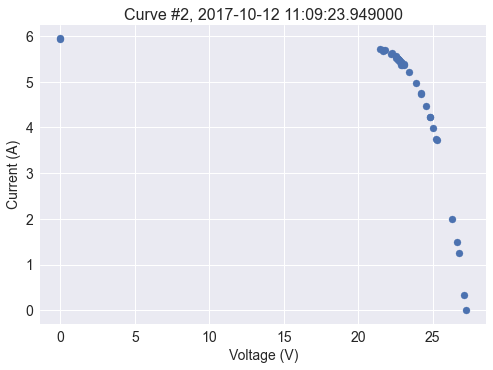

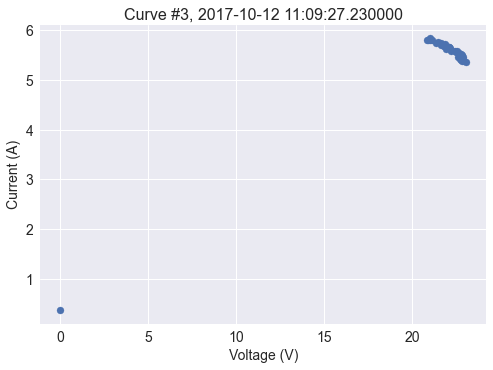

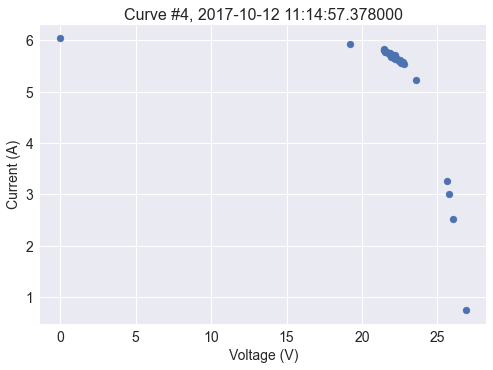

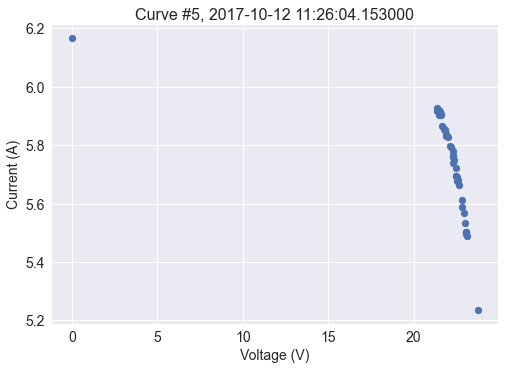

In [41]:
# Now that we've successfully played around with num_datapoints to make sure it captured enough 
# datapoints, let's see what it scrapes from our data! We only have a few IV curves in the scrape_test 
# dataset, so let's plot all those. I haven't figured out how to get plotly to do multiple graphs from 
# the same cell yet, so this will be matplotlib

# Separate out all the IV Curves using the rising edge of IV_Curves. Kind of hacky, but gets the job 
# done. 
scrape_test['edges'] = scrape_test['IV_Curves'].diff()  # Get rising/falling edges
scrape_test.loc[scrape_test['edges'] == -1, 'edges'] = 0  # Eliminate falling edges
scrape_test['curve_num'] = scrape_test['edges'].cumsum()  # Cumsum now gives you a unique curve number

IV_curves = scrape_test[scrape_test['IV_Curves'] == 1]  # Separate out just the IV Curves
IV_curves = IV_curves[['time', 'voltage', 'current','curve_num']]  # Drop irrelevant columns 

num_curves = IV_curves['curve_num'].max()
for curve_num, curve in IV_curves.groupby('curve_num'):
    
    # Plot!
    plt.figure()
    plt.scatter(curve['voltage'], curve['current'])
    plt.xlabel('Voltage (V)', size=14)
    plt.ylabel('Current (A)', size=14)
    plt.xticks(size=14)  # Change RC Params for this if you're doing lots of plotting
    plt.yticks(size=14)
    plt.title('Curve #{:.0f}, {}'.format(curve_num, curve['time'].max()), size=16)



Ok, this is looking good enough for our purposes! Looks like there might be a lower limit on the IV Curves in terms of voltage; nothing's really going below 21 V. Now, here's what's left to do:
* Turn IV Scraper into a function
* Apply that function to the other mppts' data
* Stitch all the IV Curves together into one dataframe that we can access later.
    * In a real-world scenario, we'd probably want to turn this into a SQL database if the amount of data was large enough. 

In [42]:
# Make the IV Scraper function

def scrape_IV_curves(df_in, num_datapoints=40, v_target=0, v_offset=0.01, v_col='voltage', i_col='current'):
    """
    Scrapes IV curves from a dataframe by taking x datapoints before each instance of V=0, where 
    x is num_datapoints. 

    df_in: Pandas dataframe containing time series data for current and voltage. Must have a column for current and a column for voltage
    num_datapoints: int or float-like; the number of datapoints before V=0 that you want to take for each IV curve
    v_col: name of the voltage column
    i_col: name of the current column
    """

    df = df_in.copy()  # Gets rid of pass by reference issues

    # Account for floating point errors. 
    # df['v0'] = (df['voltage'] < 0.01) & (df['voltage'] > -0.01)  # Doesn't work for all MPPTs
    df['v0'] = (df['voltage'] < (v_target + v_offset)) & (df['voltage'] > (0 - v_offset))

    # Pandas has a great rolling function that we can use to get the x datapoints before the v0
    # signal goes high. Only problem is it normally doesn't do look-ahead, so we have to use
    # the FixedForwradWindowIndexer to make that happen. 
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=num_datapoints)
    df['IV_Curves'] = df['v0'].rolling(window=indexer, center=False).max()

    # Separate out all the IV Curves using the rising edge of IV_Curves. Kind of hacky, but gets the
    # job done. 
    df['edges'] = df['IV_Curves'].diff()  # Get rising/falling edges
    df.loc[df['edges'] == -1, 'edges'] = 0  # Eliminate falling edges
    df['curve_num'] = df['edges'].cumsum()  # Cumsum now gives you a unique curve number

    # Make a new output dataframe with just IV Curves
    IV_curves = df[df['IV_Curves'] == 1]  # Separate out just the IV Curves
    IV_curves = IV_curves[['time', 'voltage', 'current','curve_num']]  # Drop irrelevant columns 

    return IV_curves

scrape_IV_curves(mppt_test)

,time,voltage,current,curve_num
640,2017-10-12 06:09:59.268,10.440000,0.00,1.0
641,2017-10-12 06:09:59.278,10.600000,0.00,1.0
642,2017-10-12 06:09:59.382,12.640000,0.17,1.0
643,2017-10-12 06:09:59.404,21.280001,0.00,1.0
644,2017-10-12 06:09:59.490,16.629999,0.00,1.0
...,...,...,...,...
383654,2017-10-12 18:28:05.598,25.100000,0.00,106.0
383655,2017-10-12 18:28:05.699,25.120001,0.00,106.0
383656,2017-10-12 18:28:05.711,25.120001,0.00,106.0
383657,2017-10-12 18:28:05.791,25.120001,0.00,106.0


In [43]:
# Now, let's stitch together all the data! May not include all the data in the final repo, since it's fairly large. 

# First step: Organize all the data inputs

mppt_IDs = ['A0', 'A1', 'B0', 'B1', 'C0', 'C1', 'D0', 'D1']
# mppt_IDs = ['C0', 'C1']
v_file = 'volt_in.csv'
i_file = 'current.csv'
prefix = 'data\\sundae_mppt_day_5\\'  # Need to use double backslash to get the proper backslash. 

v_files = [prefix + 'mppt_{}_{}'.format(id, v_file) for id in mppt_IDs]
i_files = [prefix + 'mppt_{}_{}'.format(id, i_file) for id in mppt_IDs]

mppt_files = pd.DataFrame({'ID': mppt_IDs, 'v_file': v_files, 'i_file': i_files}).set_index('ID')
mppt_files 


,v_file,i_file
ID,,
A0,data\sundae_mppt_day_5\mppt_A0_volt_in.csv,data\sundae_mppt_day_5\mppt_A0_current.csv
A1,data\sundae_mppt_day_5\mppt_A1_volt_in.csv,data\sundae_mppt_day_5\mppt_A1_current.csv
B0,data\sundae_mppt_day_5\mppt_B0_volt_in.csv,data\sundae_mppt_day_5\mppt_B0_current.csv
B1,data\sundae_mppt_day_5\mppt_B1_volt_in.csv,data\sundae_mppt_day_5\mppt_B1_current.csv
C0,data\sundae_mppt_day_5\mppt_C0_volt_in.csv,data\sundae_mppt_day_5\mppt_C0_current.csv
C1,data\sundae_mppt_day_5\mppt_C1_volt_in.csv,data\sundae_mppt_day_5\mppt_C1_current.csv
D0,data\sundae_mppt_day_5\mppt_D0_volt_in.csv,data\sundae_mppt_day_5\mppt_D0_current.csv
D1,data\sundae_mppt_day_5\mppt_D1_volt_in.csv,data\sundae_mppt_day_5\mppt_D1_current.csv


In [44]:
# Stitch it together

IV_curves = pd.DataFrame()
for mppt in mppt_IDs:
    print(mppt)
    mppt_info = mppt_files.loc[mppt, :]  # Slice out this row
    volts = pd.read_csv(mppt_info['v_file'], names=['time', 'voltage'])
    current = pd.read_csv(mppt_info['i_file'], names=['time', 'current'])

    # Correct time
    time_diff = pd.Timedelta(9.5, unit='hours')
    volts['time'] = pd.to_datetime(volts['time'], unit='ms') + time_diff
    current['time'] = pd.to_datetime(current['time'], unit='ms') + time_diff

    # Check to make sure time lines up. 
    if (volts['time'] - current['time']).max() != pd.Timedelta(0):
        raise Exception('ERROR: Time in MPPT {} does not line up'.format(mppt))

    # Merge dataframes
    single_mppt = volts.merge(current, how='left', on='time')  # Merge because on a column

    # Scrape IV Curves. Note: Had to call an audible and change how we did the filtering, since the 
    # C and D MPPTs didn't ever hit zero. So, I changed the target criteria to 10 V rather than 0 V. 
    mppt_curves = scrape_IV_curves(single_mppt, v_target=10)
    mppt_curves['mppt_id'] = mppt  # Need this to ensure each curve has a unique ID

    IV_curves = IV_curves.append(mppt_curves)

IV_curves['power'] = IV_curves['current'] * IV_curves['voltage']  # Get power in there
IV_curves['mppt_id'].unique()  # Make sure we got all the MPPTs



A0
A1
B0
B1
C0
C1
D0
D1


array(['A0', 'A1', 'B0', 'B1', 'C0', 'C1', 'D0', 'D1'], dtype=object)

Now, we get to save the IV curves! Pandas has a lot of interesting ways to save data (feather, parquet, pickle, etc.), but we're going to go with a good old excel file so that it's human-readable. Luckily, it's not a huge file so it won't be a big issue to store/read it. 

In [45]:

start = datetime.now()
IV_curves.to_excel('data/sundae_day_5_iv_curves.xlsx', index=False)
print('Time Taken to Save: {}'.format(datetime.now() - start))

Time Taken to Save: 0:00:24.552016
